# Data analysis of Auction Model

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Global variable (which was used in the batch runs)
AUCTION_LENGTH = 100

In [3]:
# 10,000 epochs of simulations
legacy_df = pd.read_csv("../data/results_legacy_bidincrease_sniper_no_watchproba.csv", index_col=0)

## Getting final row of each epoch

I.e., the winning bids of each epoch

In [4]:
splits = np.where(legacy_df["Highest Bid"] == 0)[0]
splits = np.delete(splits, 0)
splits = np.append(splits, len(legacy_df["Highest Bid"]-1))
final_rows = splits - 1
print(final_rows)

[    100     201     302 ... 1009797 1009898 1009999]


In [5]:
final_prices_df = legacy_df.iloc[final_rows]
# Removing any rows which contain 0 or None
# These are edge cases where the model does not receive any bids in the first few timesteps
final_prices_df.drop(final_prices_df.index[np.where(final_prices_df["Highest Bid"] == 0)[0]], axis=0, inplace=True)

C:\Users\Will\AppData\Local\Temp\ipykernel_11236\1367672686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_prices_df.drop(final_prices_df.index[np.where(final_prices_df["Highest Bid"] == 0)[0]], axis=0, inplace=True)


### Plotting histogram of winning bids

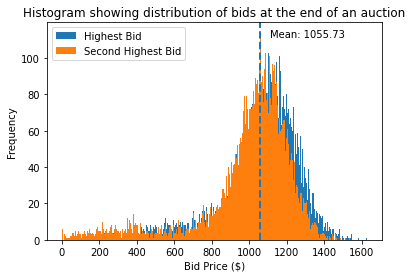

In [6]:
final_prices_df.plot.hist(bins=500)

min_ylim, max_ylim = plt.ylim()
plt.axvline(final_prices_df["Highest Bid"].mean(), linestyle='dashed', linewidth=2)
plt.text(final_prices_df["Highest Bid"].mean()*1.05, max_ylim*0.93, 'Mean: {:.2f}'.format(final_prices_df["Highest Bid"].mean()))
plt.title("Histogram showing distribution of bids at the end of an auction")
plt.xlabel("Bid Price ($)")
plt.show()

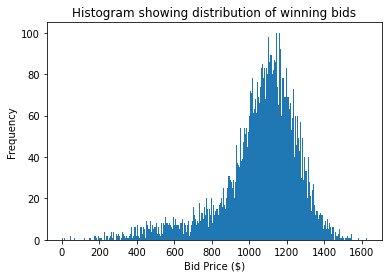

In [7]:
final_prices_df["Highest Bid"].plot.hist(bins=500)
plt.title("Histogram showing distribution of winning bids")
plt.xlabel("Bid Price ($)")
plt.show()

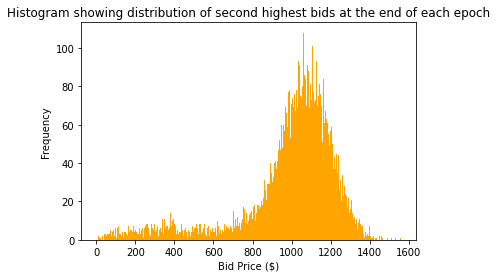

In [8]:
final_prices_df["Second Highest Bid"].plot.hist(bins=500, color="orange")
plt.title("Histogram showing distribution of second highest bids at the end of each epoch")
plt.xlabel("Bid Price ($)")
plt.show()

From these histograms, it is evident that the distribution the bidders' internal valuation and maxbids are drawn from plays a huge role in determining the nature of the auction model.

However, one notices that there is a large negative skew to the distribution, which indicates that bidProba and watchProba play an important role in the auction process.

## Calculating win ratio of EarlyBidder : SniperBidder

In [9]:
earlyBidderWinPercent = 100 * (len(np.where(final_prices_df["Highest Bidder"] == "EarlyBidder")[0]) / len(final_prices_df["Highest Bidder"]))
sniperBidderWinPercent = 100 - earlyBidderWinPercent

In [10]:
print(f'EarlyBidder win percentage: {earlyBidderWinPercent:.2f}%')
print(f'SniperBidder win percentage: {sniperBidderWinPercent:.2f}%')

EarlyBidder win percentage: 86.82%
SniperBidder win percentage: 13.18%


## Finding sniper bidder wins

Plus calculating the percentage difference between the 1st and 2nd highest bids

In [11]:
sniper_bidder_wins = final_prices_df.iloc[np.where(final_prices_df["Highest Bidder"] == "SniperBidder")[0]]

In [12]:
sniper_bidder_curse = 100 * (sniper_bidder_wins["Highest Bid"] - sniper_bidder_wins["Second Highest Bid"]) / sniper_bidder_wins["Second Highest Bid"]
print(sniper_bidder_curse)

302        12.229856
1615        0.000000
2423        7.874771
5150        4.839094
5958        0.718278
             ...    
1004141     0.793054
1004646     1.296853
1004848     0.000000
1007070     0.000000
1009494     2.295204
Length: 1318, dtype: float64


In [13]:
np.count_nonzero(sniper_bidder_curse > 13.01)

32

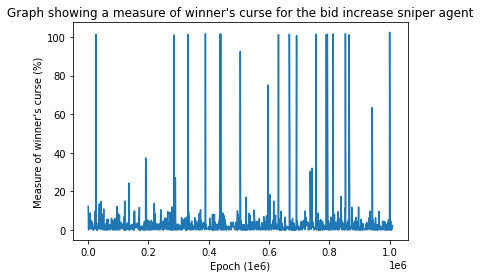

In [14]:
sniper_bidder_curse.plot()
plt.title("Graph showing a measure of winner's curse for the bid increase sniper agent")
plt.xlabel("Epoch (1e6)")
plt.ylabel("Measure of winner's curse (%)")
plt.show()

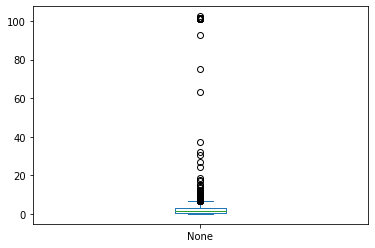

In [15]:
sniper_bidder_curse.plot.box()
plt.show()

In [16]:
mean_sniper_curse = np.mean(sniper_bidder_curse)
print(f'Mean sniper bidder curse: {mean_sniper_curse}')
median_sniper_curse = np.median(sniper_bidder_curse)
print(f'Median sniper bidder curse: {median_sniper_curse}')

Mean sniper bidder curse: 3.4850801069474335
Median sniper bidder curse: 1.3082746607132991


## Finding early bidder wins

Plus calculating the percentage difference between the 1st and 2nd highest bids

In [17]:
early_bidder_wins = final_prices_df.iloc[np.where(final_prices_df["Highest Bidder"] == "EarlyBidder")[0]]

In [18]:
early_bidder_curse = 100 * (early_bidder_wins["Highest Bid"] - early_bidder_wins["Second Highest Bid"]) / early_bidder_wins["Second Highest Bid"]
print(early_bidder_curse)

100         2.887850
201         0.859090
403        11.230767
504         1.322602
605         7.908121
             ...    
1009595     4.798343
1009696     5.022674
1009797     5.191059
1009898     7.131829
1009999     0.081127
Length: 8682, dtype: float64


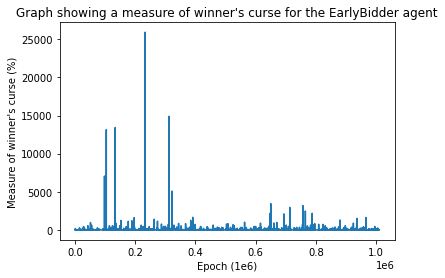

In [26]:
early_bidder_curse.plot()
plt.title("Graph showing a measure of winner's curse for the EarlyBidder agent")
plt.xlabel("Epoch (1e6)")
plt.ylabel("Measure of winner's curse (%)")
plt.show()

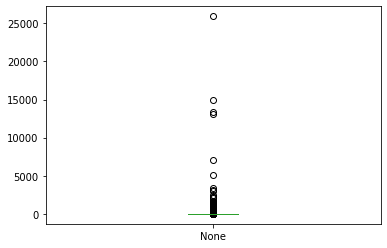

In [20]:
early_bidder_curse.plot.box()
plt.show()

In [27]:
mean_early_bidder_curse = np.mean(early_bidder_curse)
print(f'Mean early bidder curse: {mean_early_bidder_curse}')
median_early_bidder_curse = np.median(early_bidder_curse)
print(f'Median early bidder curse: {median_early_bidder_curse}')

Mean early bidder curse: 29.17679581054378
Median early bidder curse: 4.391166614794628


We can see that the early bidders paid a large premium (29%) for their win on average (mean), however the median value is much lower at 4%, showing that there was some serious outliers in the dataset

In [22]:
print(early_bidder_wins.iloc[np.argmax(early_bidder_curse)])

Highest Bid               995.729528
Highest Bidder           EarlyBidder
Second Highest Bid          3.827394
Second Highest Bidder    EarlyBidder
Name: 233309, dtype: object


## Finding mean auction bid (highest and second highest) at each timestep

In [23]:
mean_bids = legacy_df.groupby(np.arange(len(legacy_df))%(AUCTION_LENGTH+1)).mean()
print(f'Mean winning bid: {mean_bids["Highest Bid"][len(mean_bids)-1]}')

Mean winning bid: 1055.725851286921


In [24]:
mean_sniper_bidder_win = sniper_bidder_wins["Highest Bid"].mean()
mean_early_bidder_win = early_bidder_wins["Highest Bid"].mean()

print(f'Mean winning bid (SniperBidder): {mean_sniper_bidder_win}')
print(f'Mean winning bid (EarlyBidder): {mean_early_bidder_win}')

Mean winning bid (SniperBidder): 1045.1597253651996
Mean winning bid (EarlyBidder): 1057.3298773137383


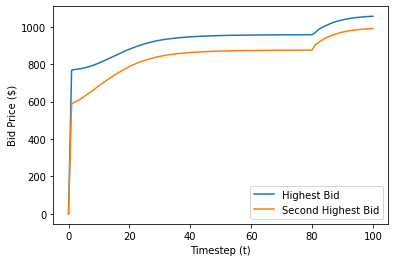

In [25]:
mean_bids.plot()
plt.ylabel("Bid Price ($)")
plt.xlabel("Timestep (t)")
plt.show()

The noticeable jump from timestep 80 onwards characterises the SniperBidders being activated (for this dataset, bidTimeframe was set to 20). 